## CBS Week 6 Tutorial: Episodic Memory



In [1]:
library(neuralnet)
library(testthat)
options(warn=-1)

# turn a list into a string
strList = function(lst){
    paste(unlist(lst), collapse=' ')
}

## The Search of Associative Memory (SAM) model of Recall

In the tutorial this week, we will solidify the exposition of the Search of Associative Memory (SAM) model that we
discussed in class. SAM is designed to capture memory encoding and retrieval processes and has been used to model free and cued recall (Raaijmakers & Shiffrin, 1981) and recognition memory (Gillund & Shiffrin, 1984). Today we are just going to focus on the recall model.

### Encoding

When a subject is studying a list, SAM assumes that the study items enter Short Term Store (STS) one at a time. STS is assumed to be capcity limited. Typically, the capacity is assumed to be 4 and that is the value we will use in the following exercises. Once the STS is full, an item must be selected to exit the STS to make room for the new item. Choosing which item should leave STS is done probabilistically based on the following formula:

$\Large p(i) = \frac{q (1-q)^{i-1}}{1-(1-q)^4}$

The q parameter controls how flat the distribution is. When q is very small the model chooses items to remove with unifrm probability. The q is close to one, the model chooses the item that entered memory last with high probability. In the following cell the probs variable contains the probabilities with which items will be removed. By changing q and recalculating you can see how the probabilities  change. Be sure to set it back to 0.2 before you move on though, as that will be important for later exercises.


In [2]:
q = 0.2 # the parameter that controls the probabilities with which items are chosen to exit STS
ind = c(1,2,3,4)
probs = sapply(ind, function (i) {q * (1-q)**(i-1)/(1-(1-q)**4)}) # probabilites of removing items from STS
probs

[1] 0.3387534 0.2710027 0.2168022 0.1734417

The SAM model assumes that in addition to the STS there is a Long Term Store (LTS) that contains associations between items that persist indefinitely. The LTS weights start with a value that we will call the Baseline. While an item is in STS, the model assumes that weights in LTS are increased. There are four kinds of associations. Self weights capture the strength of the association between an item and itself. Forward weights capture the association between items and those that occur immediately after them in STS. Backward weights capture the strength of the association between an item and the item that appears immediately before it in STS, and Context weights capture the association between the item and a node representing the list context. 

In the next cell, we define the parameters that control the amount by which these associations are increased on each encoding opportunity. Note that the Forward parameter is greater than the Backward parameter reflecting the tendency for people to recall in forward serial order - even in free recall where this is not a requirement of the task. 

In [3]:
Baseline = 0.5 # the baseline strength that all items have to each other prior to learning the list
Self = 1. # the increment in the weight of an item to itself
Forward = 1.5 # the increment from an item to what appears after it in the STS
Backward = .5 # the increment from an item to what appears before it in the STS
Context = 1 # the increment in the weight from the context to the item 


Prior to simulating a participant studying a list, we must initalize the stores. The STS just starts as the empty list as our simulated participant has yet to see any items. The LTS starts with a matrix of strengths all set to the Baseline value. Note that in addition to the Context and study list item nodes, we have included a node called X. Occasionally, people produce words that did not appear on the list. The model captures all of these possible responses with the X node - that is, if the model produces X as a response that is equivalent to it producing an out of list item regardless of what it may be. X needs to appear in teh matrix of associations both as a possible response and as an input because if the simulated participant produces the X response, it needs to have a Forward strength to other items in order for recall to continue.

initStores allows you to reset the contents of the stores in preparation for studying a list. We include the items of hte list that is about to be studied, just so we can set the labels on the dataframe.  

In [4]:
initStores = function(study){
    STS <<- list()
    L <<- length(study)+1
    LTS <<- data.frame(matrix(1, L+1, L)*Baseline)
    colnames(LTS) <<- c(study, c("X"))
    rownames(LTS) <<- c(study, c("X", "Context"))
}

study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key", "Rose", "Boat")
initStores(study)
LTS

,House,Shoe,Tree,Car,Dog,Key,Rose,Boat,X
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
House,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Shoe,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Tree,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Car,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Dog,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Key,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Rose,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Boat,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
X,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


Now that we have initialized the STS and LTS it is time to simulate the encoding process. The studyitem function simulates the presentation of a single item. If the STS is full (i.e. has four items in it) then we have to remove one of those items to make room for our next item. We choose which one using the formula presented above and set the item to NULL to remove it. Then we enter the new item by appending it to the STS.

Next we consider each of the items in STS in turn and update the LTS weights based on Context, Self, Forward and Backward parameters. Note that in each case, the increment is divided by the number of items currently in the STS, capturing the idea that if there are fewer items in STS there is more attention that can be applied to learning each one.

Finally, we take function that simulates what happens when a single item is presented, and run for each item in the study list.

Run the following cell and consider the STS and the LTS values at the end.

In [5]:
studyitem = function(item){
    if (length(STS) == 4){
        # select item to be removed
        r = sample(c(1, 2, 3, 4), size = 1, prob = probs)
        STS[r] <<- NULL       
    }
    STS <<- append(STS, item)
    l = length(STS)
    for (i in 1:l){
        iname = STS[[i]]
        LTS["Context",iname] <<- LTS["Context", iname] + Context/l
        LTS[iname,iname] <<- LTS[iname,iname] + Self/l
        if (i < l){
            for (j in (i+1):l){
                jname = STS[[j]]
                LTS[iname,jname] <<- LTS[iname,jname] + Forward/l
                LTS[jname,iname] <<- LTS[jname,iname] + Backward/l
            }
        }
    }
}

studylist = function(study){
    initStores(study)
    for (word in study){
        studyitem(word)
    }
}

studylist(study)
LTS
STS

,House,Shoe,Tree,Car,Dog,Key,Rose,Boat,X
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
House,2.5833333,2.1250000,1.375000,0.875,0.500,0.500,0.500,0.500,0.5
Shoe,1.0416667,1.8333333,1.750000,1.250,0.875,0.500,0.500,0.500,0.5
Tree,0.7916667,0.9166667,1.583333,1.625,1.250,0.875,0.500,0.500,0.5
Car,0.6250000,0.7500000,0.875000,1.750,1.625,1.625,1.250,0.875,0.5
Dog,0.5000000,0.6250000,0.750000,0.875,1.250,1.250,0.875,0.500,0.5
Key,0.5000000,0.5000000,0.625000,0.875,0.750,1.250,1.250,0.875,0.5
Rose,0.5000000,0.5000000,0.500000,0.750,0.625,0.750,1.000,0.875,0.5
Boat,0.5000000,0.5000000,0.500000,0.625,0.500,0.625,0.625,0.750,0.5
X,0.5000000,0.5000000,0.500000,0.500,0.500,0.500,0.500,0.500,0.5


[[1]]
[1] "Car"

[[2]]
[1] "Key"

[[3]]
[1] "Rose"

[[4]]
[1] "Boat"

### Recall

Now that we have simulated the encoding process, we can initiate recall. There are three phases to recall according to SAM:

* Report the items that are still in STS
* Use the context cue by itself to initiate retrieval of the first of the remaining items:

$\Large p_{sampling}(i|context)=\frac{S(i,context)}{\sum_{k=1}^N S(k,context)}$

Then decide if it can be retrieved using the following:

$\Large p_{recall}(i|context)=1-e^{-S(i,context)}$

* The use the context cue and the preceding item to retreive subsequent items using the following formula:

$\Large p_{sampling}(i|j, context)=\frac{S(i,j) S(i,context)}{\sum_{k=1}^N S(k,j)S(k,context)}$

$\Large p_{recall}(i|j, context)=1-e^{-S(i,context)-S(i,j)}$

Recall continues until there have been k unsuccessful attempts to retrieve. 

The following code simulates recalling a list. It returns the list that was recalled. 

In [6]:
recall = function(k = 3){
    possibleoutputs = c(study, "X")
    numberAttempts = 0
    addWord = FALSE
    
    # first retrieve items from STS
    
    result = STS
    
    # now use context to retrieve the first of the remaining items
    
    sampleprobs = LTS["Context",]/sum(LTS["Context",])
    while (numberAttempts < k && !addWord){
        nextword = sample(possibleoutputs, size=1, prob = sampleprobs)
        recallprob = 1 - exp(-LTS["Context", nextword])
        didrecall = sample(c(0,1), size=1, prob = c(1-recallprob, recallprob))
        if (didrecall == 1){
            addWord = !(nextword %in% result)
            if (addWord){
                result = append(nextword, result)
            } else {
                numberAttempts = numberAttempts + 1
            } 
        } else {
            numberAttempts = numberAttempts + 1 
        }
    }
    
    # now use context and last item to retrieve items
    
    while (numberAttempts < k){
        sampleprobs = (LTS["Context",]*LTS[nextword,])/(sum(LTS["Context",]*LTS[nextword,])+0.00001)
        lastword = nextword
        nextword = sample(possibleoutputs, size=1, prob = sampleprobs)
        recallprob = 1 - exp(-LTS["Context", nextword]-LTS[lastword, nextword])
        didrecall = sample(c(0,1), size=1, prob = c(1-recallprob, recallprob))
        if (didrecall == 1){
            addWord = !(nextword %in% result)
            if (addWord){
                result = append(nextword, result)
            } else {
                numberAttempts = numberAttempts + 1
            }
        } else {
            numberAttempts = numberAttempts + 1 
        }
    }
    rev(result)
}
recall()
LTS


[[1]]
[1] "Boat"

[[2]]
[1] "Rose"

[[3]]
[1] "Key"

[[4]]
[1] "Car"

[[5]]
[1] "Tree"

,House,Shoe,Tree,Car,Dog,Key,Rose,Boat,X
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
House,2.5833333,2.1250000,1.375000,0.875,0.500,0.500,0.500,0.500,0.5
Shoe,1.0416667,1.8333333,1.750000,1.250,0.875,0.500,0.500,0.500,0.5
Tree,0.7916667,0.9166667,1.583333,1.625,1.250,0.875,0.500,0.500,0.5
Car,0.6250000,0.7500000,0.875000,1.750,1.625,1.625,1.250,0.875,0.5
Dog,0.5000000,0.6250000,0.750000,0.875,1.250,1.250,0.875,0.500,0.5
Key,0.5000000,0.5000000,0.625000,0.875,0.750,1.250,1.250,0.875,0.5
Rose,0.5000000,0.5000000,0.500000,0.750,0.625,0.750,1.000,0.875,0.5
Boat,0.5000000,0.5000000,0.500000,0.625,0.500,0.625,0.625,0.750,0.5
X,0.5000000,0.5000000,0.500000,0.500,0.500,0.500,0.500,0.500,0.5


Given the model makes some choices at random, to explore it's properties, we need to simulate many participants and see what the behaviour patterns are. In particular, in free recall we are interested to see if the model captures the serial position curve. The following code simulates 400 people completing one list each and plots the serial position curve.

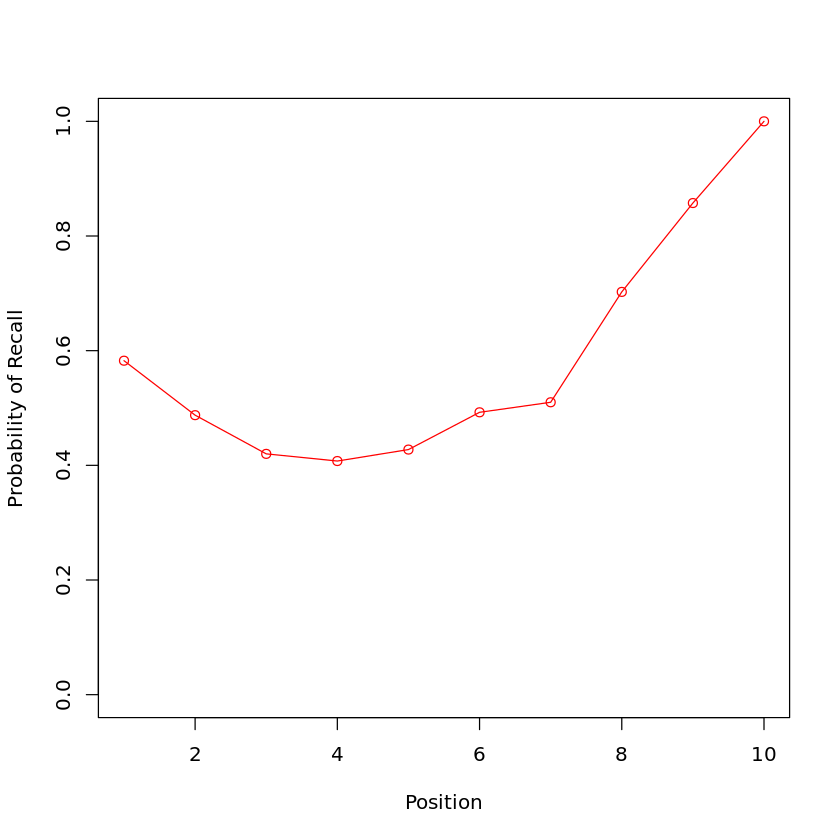

In [7]:
serialposition = function(study){
    L = length(study)
    positioncounts = data.frame(rep(0, L))
    NumberOfIterations = 400

    for (iteration in 1:NumberOfIterations){
        studylist(study)
        result = recall()
        for (position in 1:L){
            if (study[position] %in% result){
                positioncounts[position,1] = positioncounts[position,1] + 1
            }
        }
        
    }
    t(as.matrix(positioncounts/NumberOfIterations))
}

study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key", "Rose", "Boat", "Paper", "Foot")
sp10 = serialposition(study)
plot(1:10, sp10, type="o", xlab="Position", ylab="Probability of Recall", ylim=c(0, 1.0), col="red")



The following graph shows the data from people collected by Murdock (1962). You can see that the model is capturing the primacy and recency effects well.

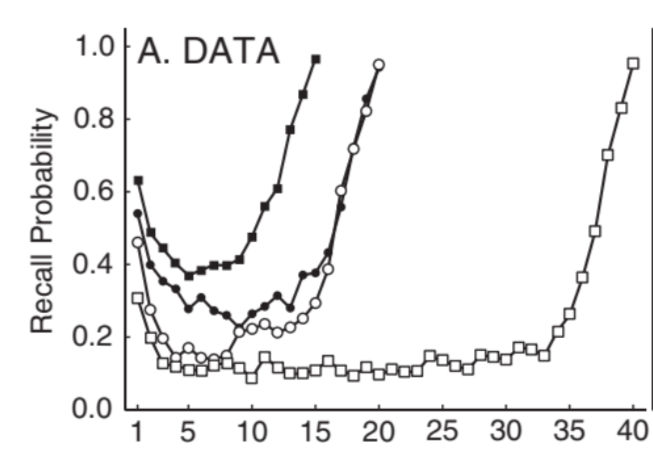

## Exercise 1 (3 points)

Now write code to change the length of the list and plot the curves for a 6 item, 8 item and 10 item list on the same graph. Your graph should look like this:

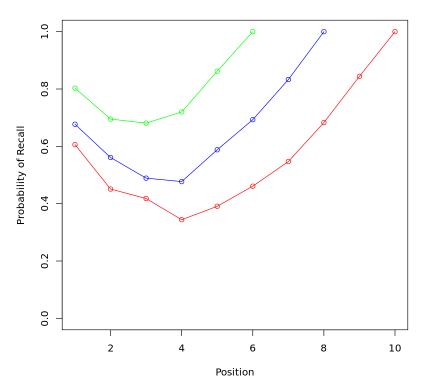

Hint: You will need to use the lines R function to add additional data to the same plot.

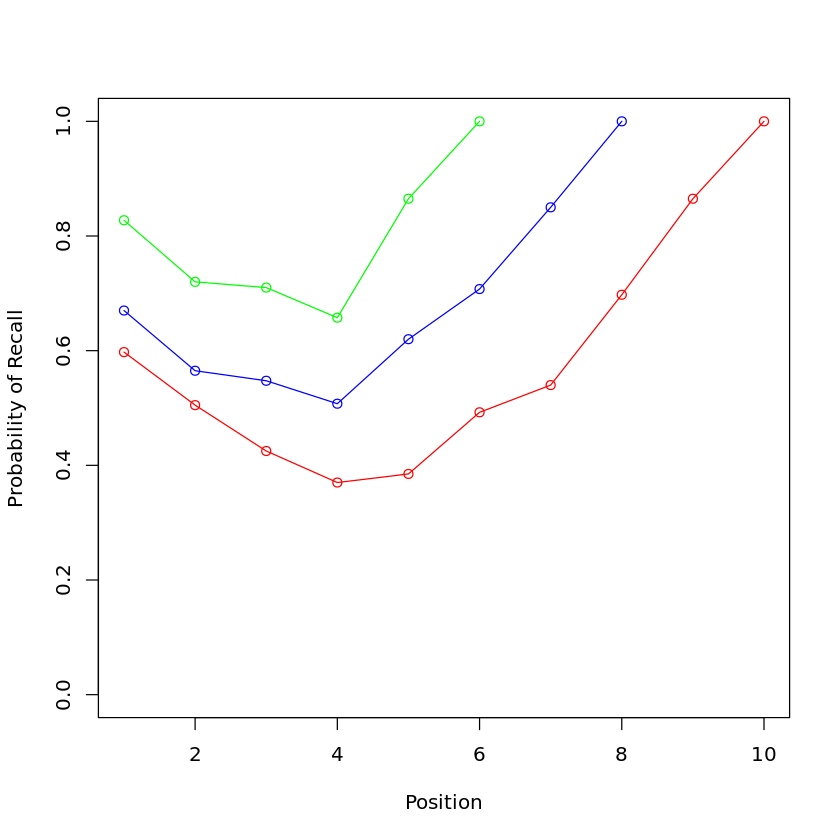

In [8]:
### BEGIN HIDDEN SOLUTION
study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key", "Rose", "Boat", "Paper", "Foot")
sp10 = serialposition(study)
plot(1:10, sp10, type="o", xlab="Position", ylab="Probability of Recall", ylim=c(0, 1.0), col="red")

study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key", "Rose", "Boat")
sp8 = serialposition(study)
lines(1:8, sp8, type="o", col="blue")

study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key")
sp6 = serialposition(study)
lines(1:6, sp6, type="o", col="green")
### END HIDDEN SOLUTION

## Exercise 2 (2 points)

As the length of the list increases the probability of recalling a given item drops. That is, there is a list length effect. What factors lead to the list length effect?

=== BEGIN MARK SCHEME ===
There are two main factors that lead to the list length effect in SAM. Firstly, recall starts by retrieving the items 
from STS. In shorter lists a greater proportion of the items are in STS. Secondly, the probability of retrieving any given 
item during sampling decreases if there are more items competing. Each time a retrieval occurs there is a chance it will be 
one of the already selected items and htat probability increases as the number of recalled items increases making it more 
likely that the simulation stops before recalling the remaining items.
=== END MARK SCHEME ===


## Exercise 3 (4 points)

As we discussed in class, when a delay is introduced after the end of the study list, the recency part of the curve drops down (provided the delay is filled with other activity so that the participants cannot rehearse the study items). According to SAM, this occurs because the STS no longer contains relevant items and is therefore not used in retireval. Copy the recall code from above and modify it to simulate the introduction of a delay. Then plot the serial position curves again.

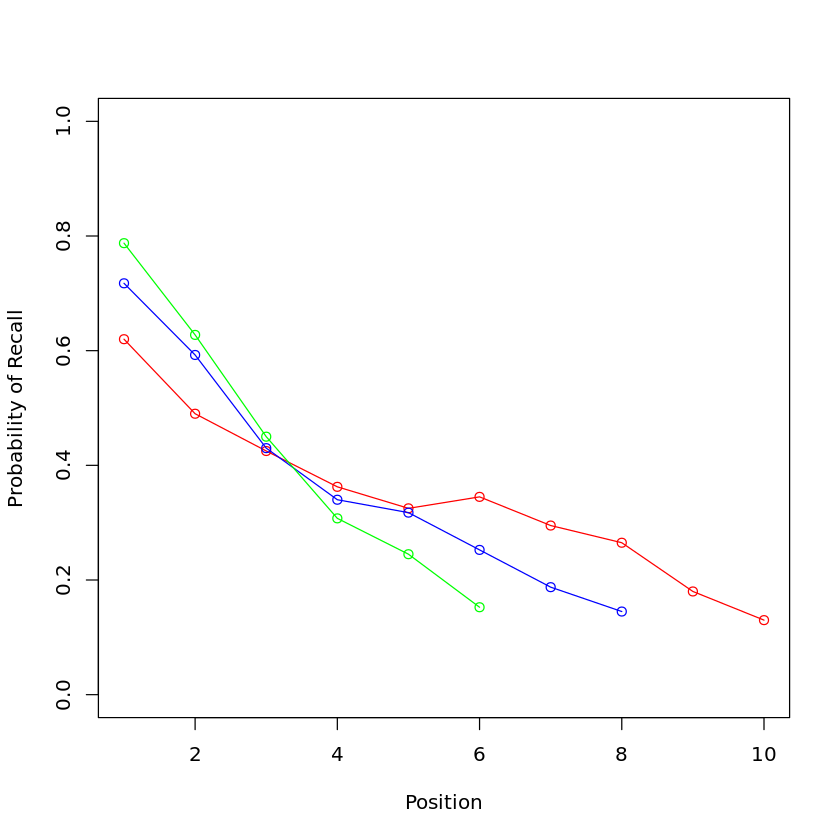

In [9]:
### BEGIN HIDDEN SOLUTION

recall = function(k = 3){
    possibleoutputs = c(study, "X")
    numberAttempts = 0
    addWord = FALSE
    
    # first retrieve items from STS
    
    result = list()
    
    # now use context to retrieve the first item
    
    sampleprobs = LTS["Context",]/sum(LTS["Context",])
    while (numberAttempts < k && !addWord){
        nextword = sample(possibleoutputs, size=1, prob = sampleprobs)
        recallprob = 1 - exp(-LTS["Context", nextword])
        didrecall = sample(c(0,1), size=1, prob = c(1-recallprob, recallprob))
        if (didrecall == 1){
            addWord = !(nextword %in% result)
            if (addWord){
                result = append(nextword, result)
            } else {
                numberAttempts = numberAttempts + 1
            } 
        } else {
            numberAttempts = numberAttempts + 1 
        }
    }
    
    # now use context and last item to retrieve items
    
    while (numberAttempts < k){
        sampleprobs = (LTS["Context",]*LTS[nextword,])/(sum(LTS["Context",]*LTS[nextword,])+0.00001)
        nextword = sample(possibleoutputs, size=1, prob = sampleprobs)
        recallprob = 1 - exp(-LTS["Context", nextword])
        didrecall = sample(c(0,1), size=1, prob = c(1-recallprob, recallprob))
        if (didrecall == 1){
            addWord = !(nextword %in% result)
            if (addWord){
                result = append(nextword, result)
            } else {
                numberAttempts = numberAttempts + 1
            }
        } else {
            numberAttempts = numberAttempts + 1 
        }
    }
    rev(result)
}


study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key", "Rose", "Boat", "Paper", "Foot")
sp10 = serialposition(study)
plot(1:10, sp10, type="o", xlab="Position", ylab="Probability of Recall", ylim=c(0, 1.0), col="red")

study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key", "Rose", "Boat")
sp8 = serialposition(study)
lines(1:8, sp8, type="o", col="blue")

study <- c("House", "Shoe", "Tree", "Car", "Dog", "Key")
sp6 = serialposition(study)
lines(1:6, sp6, type="o", col="green")
### END HIDDEN SOLUTION

## Exercise 4 (2 points)

The shorter lists show stronger primacy effects - why is that?

=== BEGIN MARK SCHEME ===
Shorter lists have fewer items and less competition for retrival.
=== END MARK SCHEME ===

## Exercise 5 (2 points)

Position 6 for the 6-item list performs worse than position 6 for the 8 or 10 item lists. Why is that?

=== BEGIN MARK SCHEME ===
In the six item list, the sixth item is also the last item and so there are no subsequent study opportunties on which it can appear in STS and be strengthened. For the eight item list there are two opportunities for it to be strengthened and in the 10 item list there are four opportunities for it to be strengthened.
=== END MARK SCHEME ===

That is the end of the tutorial on recall in the Search of Associative Memory (SAM) model. There are many other issues that can be explored in SAM - in particular it is instructive to manipulate the parameters and observe the effects they have on retrieval. Feel free to do that if you are interested. 

More generally, SAM is an exemplar of a process oriented cognitive model. It attempts to capture the nature not just of the outputs that the recall process produces, but also the storage structures and the algorithm by which it is accomplishing the task. This stands in contrast to the probabilistic models you covered in the first module of the class, where the emphasis is on identifying the information (in the form of likelihoods and priors) that are important to the task, while remaining agnostic about the algorithms that cognitive system is performing. 